Number of training examples = 104397
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Traffic Sign number: 31
Original


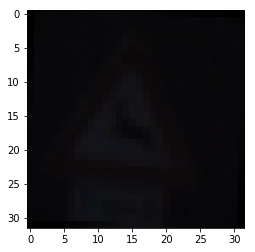

5 degrees


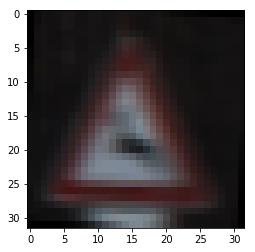

-5 degrees


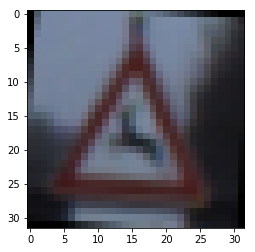

Training...

EPOCH 1 ...
Validation Accuracy = 0.864

EPOCH 2 ...
Validation Accuracy = 0.912

EPOCH 3 ...
Validation Accuracy = 0.924

EPOCH 4 ...
Validation Accuracy = 0.915

EPOCH 5 ...
Validation Accuracy = 0.937

EPOCH 6 ...
Validation Accuracy = 0.926

EPOCH 7 ...
Validation Accuracy = 0.940

EPOCH 8 ...
Validation Accuracy = 0.936

EPOCH 9 ...
Validation Accuracy = 0.934

EPOCH 10 ...
Validation Accuracy = 0.941

EPOCH 11 ...
Validation Accuracy = 0.927

EPOCH 12 ...
Validation Accuracy = 0.926

EPOCH 13 ...
Validation Accuracy = 0.943

EPOCH 14 ...
Validation Accuracy = 0.936

EPOCH 15 ...
Validation Accuracy = 0.944

EPOCH 16 ...
Validation Accuracy = 0.933

EPOCH 17 ...
Validation Accuracy = 0.937

EPOCH 18 ...
Validation Accuracy = 0.941

EPOCH 19 ...
Validation Accuracy = 0.946

EPOCH 20 ...
Validation Accuracy = 0.938

EPOCH 21 ...
Validation Accuracy = 0.931

EPOCH 22 ...
Validation Accuracy = 0.951

EPOCH 23 ...
Validation Accuracy = 0.934

EPOCH 24 ...
Validation Accura

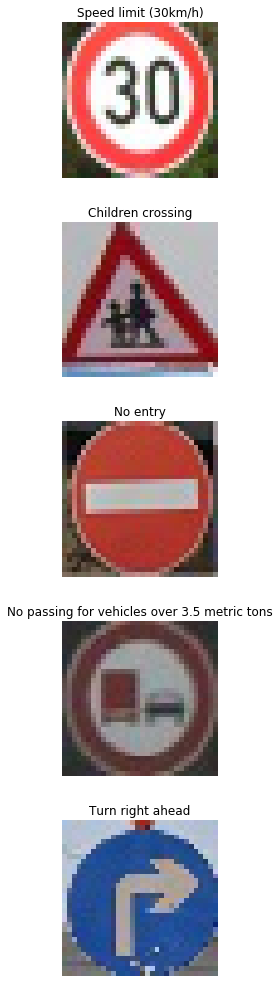

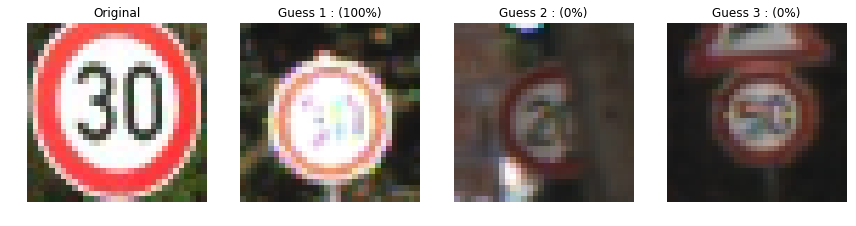

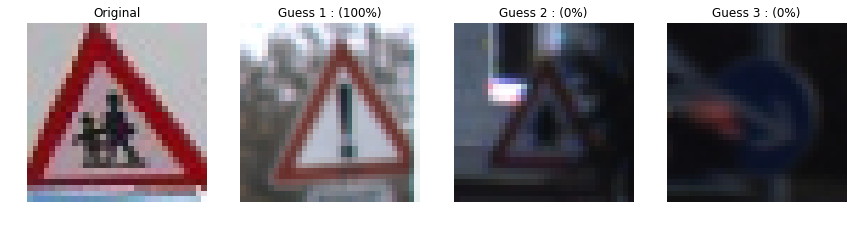

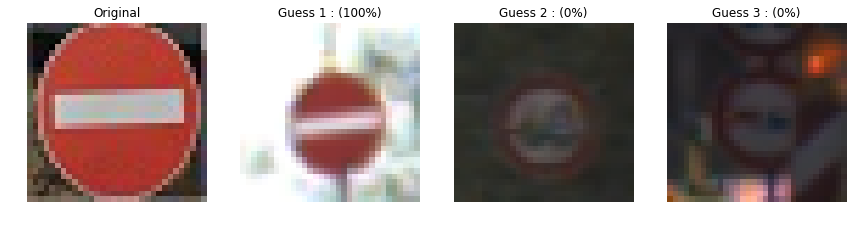

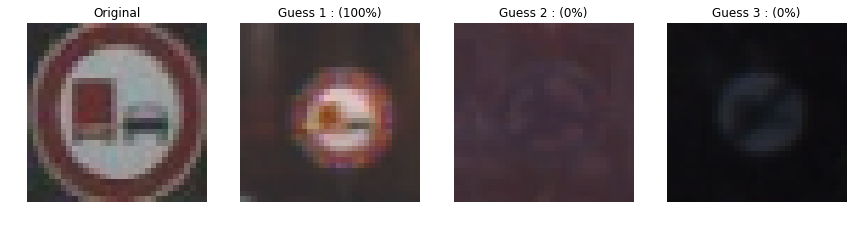

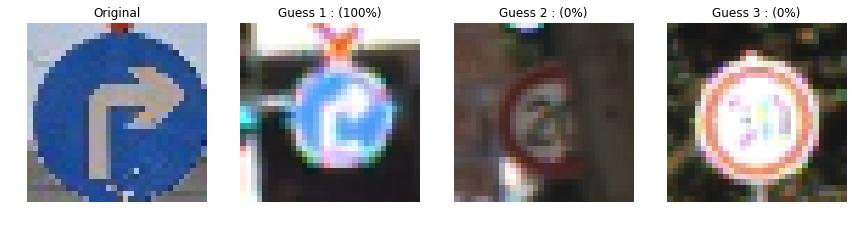

In [24]:
###################################################################
##    Project 2: Build a Traffic Sign Recognition Classifier
###################################################################

###################################################################
##    Step 0: Load the data
###################################################################
# Load pickled data
import pickle
import pandas as pd
from skimage import io

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"
signnames = pd.read_csv('signnames.csv')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

import numpy as np
import cv2


##   Function for rotates images
def rotateImage(image, angle):

    rows,cols,colors = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(image.squeeze(),M,(cols,rows))
    return dst

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

e = 0

size_train = len(X_train)

temp_x_train = X_train.copy()
temp_y_train = y_train.copy()
temp_x_train_2 = X_train.copy()
temp_y_train_2 = y_train.copy()

## we rotates the image 5 degrees and -5 degrees
for e in range(size_train):
    temp_x_train[e] = rotateImage(X_train[e], 5)
    temp_y_train[e] = y_train[e]
    temp_x_train_2[e] = rotateImage(X_train[e], -5)
    temp_y_train_2[e] = y_train[e] 

## we add the rotate image images in the train dataset
X_train = np.concatenate((X_train, temp_x_train), axis=0)
y_train = np.concatenate((y_train, temp_y_train), axis=0)

X_train = np.concatenate((X_train, temp_x_train_2), axis=0)
y_train = np.concatenate((y_train, temp_y_train_2), axis=0)

###################################################################
##    Step 1: Dataset Summary & Exploration
###################################################################

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = signnames.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import glob
import cv2
import numpy as np

def plot_figures(figures, nrows, ncols, labels=None):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 14))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        if(labels != None):
            axs[index].set_title(labels[index])
        else:
            axs[index].set_title(title)

        axs[index].set_axis_off()

    plt.tight_layout()


    
    
name_values = np.genfromtxt('signnames.csv', skip_header=1, dtype=[('myint','i8'), ('mysring','S55')], delimiter=',')

index = random.randint(0, len(X_train))
print("Traffic Sign number:", y_train[index])

list_labels = np.array([])
list_figures = np.array([])
my_labels = np.array([index])


image = X_train[index].squeeze()
print("Original")
plt.figure()
plt.imshow(image)
plt.show()


image = X_train[index+43].squeeze()
print("5 degrees")
plt.figure()
plt.imshow(image)
plt.show()

image = X_train[index+86].squeeze()
print("-5 degrees")
plt.figure()
plt.imshow(image)
plt.show()

###################################################################
##    Step 2: Design and Test a Model Architecture
###################################################################

### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
    
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

    
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    #sigma = 0.1
    sigma = 0.05
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout for L2
    #conv2 = tf.nn.dropout(conv2, 0.90)    

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout for L3
    fc1 = tf.nn.dropout(fc1, 0.99)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})   
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
###################################################################
##    Step 3: Test a Model on New Images
###################################################################

### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.   

my_images = sorted(glob.glob('./traffic_images/*.jpg'))
my_labels = np.array([1, 28, 17, 10, 33])
name_values = np.genfromtxt('signnames.csv', skip_header=1, dtype=[('myint','i8'), ('mysring','S55')], delimiter=',')

figures = {}
labels = {}
my_signs = []
index = 0
for my_image in my_images:
    img = cv2.cvtColor(cv2.imread(my_image), cv2.COLOR_BGR2RGB)
    my_signs.append(img)
    figures[index] = img
    labels[index] = name_values[my_labels[index]][1].decode('ascii')
    index += 1

plot_figures(figures, 5, 1, labels)


### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

my_signs = np.array(my_signs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    my_accuracy = evaluate(my_signs, my_labels)
    print("My Data Set Accuracy = {:.3f}".format(my_accuracy))

### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
my_single_item_array = []
my_single_item_label_array = []

i = 0

for i in range(5):
    my_single_item_array.append(my_signs[i])
    my_single_item_label_array.append(my_labels[i])

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, "./lenet")
        my_accuracy = evaluate(my_single_item_array, my_single_item_label_array)
        print('Image {}'.format(i+1))
        print("Image Accuracy = {:.3f}".format(my_accuracy))
        print()

k_size = 3
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=k_size, sorted=True, name='softmax1')
with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_signs})
    my_top_k = sess.run(top_k, feed_dict={x: my_signs})
    ### Output Top 5 Softmax Probabilities For Each Image Found on the Web
    print(my_top_k)
    for i in range(5):
        figures = {}
        labels = {}       
        figures[0] = my_signs[i]
        labels[0] = "Original"       
        for j in range(k_size):
            labels[j+1] = 'Guess {} : ({:.0f}%)'.format(j+1, 100*my_top_k[0][i][j])
            figures[j+1] = X_valid[np.argwhere(y_valid == my_top_k[1][i][j])[0]].squeeze()
        plot_figures(figures, 1, 4, labels) 
        ymax = figures[0].max()
        ymin = figures[0].min()    